<a href="https://colab.research.google.com/github/karthikeya-kar/amazon-ml/blob/main/amazon_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded = files.upload()
import pandas as pd




Saving train.csv to train.csv


In [5]:
import pandas as pd

# Load the training dataset
df_train = pd.read_csv('/content/train.csv')  # Replace 'path_to_train.csv' with the actual file name

# Display the first few rows of the dataset
print(df_train.head())


                                          image_link  group_id  entity_name  \
0  https://m.media-amazon.com/images/I/61I9XdN6OF...    748919  item_weight   
1  https://m.media-amazon.com/images/I/71gSRbyXmo...    916768  item_volume   
2  https://m.media-amazon.com/images/I/61BZ4zrjZX...    459516  item_weight   
3  https://m.media-amazon.com/images/I/612mrlqiI4...    459516  item_weight   
4  https://m.media-amazon.com/images/I/617Tl40LOX...    731432  item_weight   

     entity_value  
0      500.0 gram  
1         1.0 cup  
2      0.709 gram  
3      0.709 gram  
4  1400 milligram  


In [6]:
print(df_train.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263859 entries, 0 to 263858
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   image_link    263859 non-null  object
 1   group_id      263859 non-null  int64 
 2   entity_name   263859 non-null  object
 3   entity_value  263859 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.1+ MB
None


In [7]:
print(df_train['entity_name'].unique())


['item_weight' 'item_volume' 'voltage' 'wattage'
 'maximum_weight_recommendation' 'height' 'depth' 'width']


In [8]:
print(df_train['entity_name'].value_counts())


entity_name
item_weight                      102786
depth                             45127
width                             44183
height                            43597
voltage                            9466
wattage                            7755
item_volume                        7682
maximum_weight_recommendation      3263
Name: count, dtype: int64


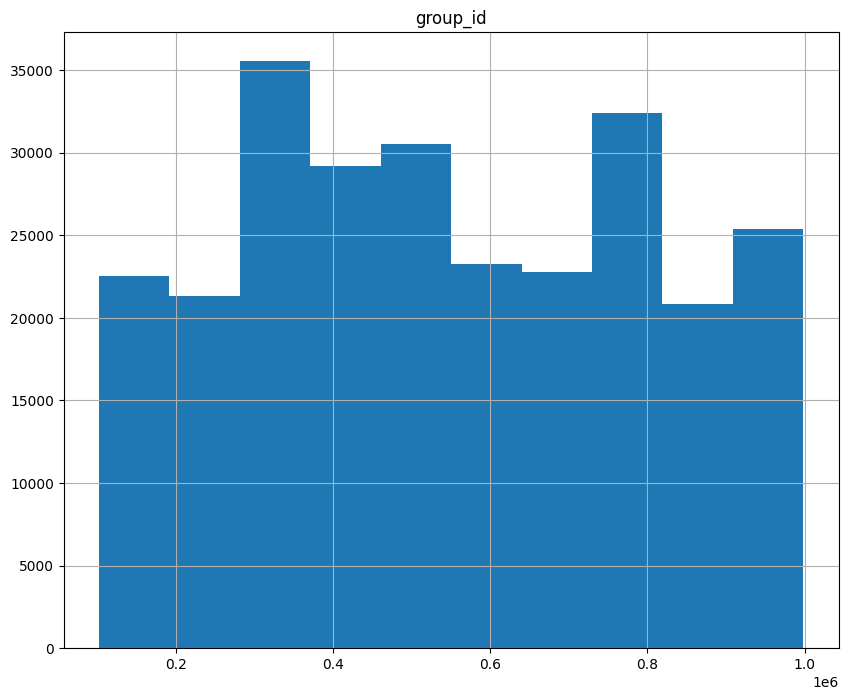

KeyboardInterrupt: 

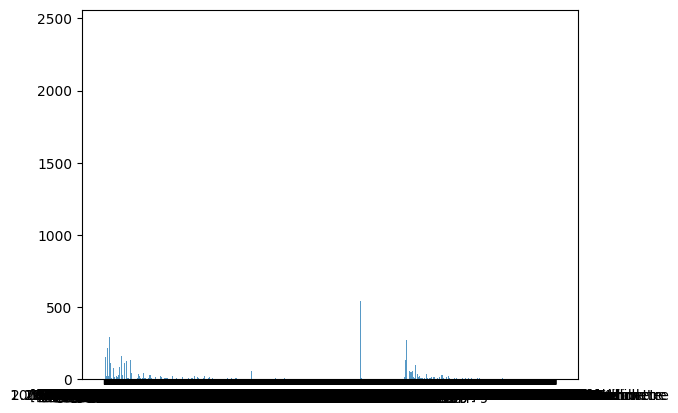

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for numeric columns
df_train.hist(figsize=(10, 8))
plt.show()

# Plot distributions of specific columns
sns.histplot(df_train['entity_value'])
plt.show()


In [10]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
print(df_train)


In [11]:
print(df_train.sample(10))  # Adjust the number of samples as needed



                                               image_link  group_id  \
258994  https://m.media-amazon.com/images/I/51NSSSC9Fs...    437623   
40203   https://m.media-amazon.com/images/I/619bHowYx4...    308856   
25167   https://m.media-amazon.com/images/I/71j12KTsJW...    179080   
228185  https://m.media-amazon.com/images/I/51Zrzm6jfe...    810266   
9963    https://m.media-amazon.com/images/I/71NG+3RQJm...    523149   
159581  https://m.media-amazon.com/images/I/61FE7zxRMQ...    931247   
88476   https://m.media-amazon.com/images/I/61WyWxihfC...    767202   
93510   https://m.media-amazon.com/images/I/61Upl5AzL8...    221399   
228034  https://m.media-amazon.com/images/I/51dTfpOHge...    849273   
233535  https://m.media-amazon.com/images/I/61EaS6x9++...    594224   

                          entity_name     entity_value  
258994                         height  11.3 centimetre  
40203                     item_weight       1 kilogram  
25167                         voltage        48

In [12]:
!pip install requests pillow

import requests
from PIL import Image
from io import BytesIO
import pandas as pd
import os

# Load the dataset (ensure the file path is correct)
df = pd.read_csv('/content/train.csv')  # Replace with your actual CSV file path

# Function to download and save an image
def download_image(url, file_path):
    try:
        # Send a GET request to the URL
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Open the image using PIL
            img = Image.open(BytesIO(response.content))
            # Save the image locally
            img.save(file_path)
            print(f"Image downloaded and saved as '{file_path}'")
        else:
            print(f"Failed to retrieve the image from {url}")
    except Exception as e:
        print(f"Error processing image from {url}: {e}")

# Directory where images will be saved
output_dir = '/content/images'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Iterate over the DataFrame and download images
for idx, row in df.iterrows():
    url = row['image_link']
    # Construct the filename using index or another unique identifier
    file_path = os.path.join(output_dir, f'image_{idx}.jpg')  # Ensure unique filenames
    download_image(url, file_path)

# List files in the output directory
print(os.listdir(output_dir))


Streaming output truncated to the last 5000 lines.
Image downloaded and saved as '/content/images/image_7121.jpg'
Image downloaded and saved as '/content/images/image_7122.jpg'
Image downloaded and saved as '/content/images/image_7123.jpg'
Image downloaded and saved as '/content/images/image_7124.jpg'
Image downloaded and saved as '/content/images/image_7125.jpg'
Image downloaded and saved as '/content/images/image_7126.jpg'
Image downloaded and saved as '/content/images/image_7127.jpg'
Image downloaded and saved as '/content/images/image_7128.jpg'
Image downloaded and saved as '/content/images/image_7129.jpg'
Image downloaded and saved as '/content/images/image_7130.jpg'
Image downloaded and saved as '/content/images/image_7131.jpg'
Image downloaded and saved as '/content/images/image_7132.jpg'
Image downloaded and saved as '/content/images/image_7133.jpg'
Image downloaded and saved as '/content/images/image_7134.jpg'
Image downloaded and saved as '/content/images/image_7135.jpg'
Imag

KeyboardInterrupt: 